# Loading Dataset

In [7]:
# import dataset
from google.colab import files
uploaded = files.upload()  # then select your CSV file


Saving IMDB Dataset.csv to IMDB Dataset.csv


In [8]:
import pandas as pd

df = pd.read_csv("IMDB Dataset.csv")
print(df.head())
print(df['sentiment'].value_counts())  # see how many positive/negative reviews


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


# Preprocessing

In [9]:
import re

# minor text cleaning for DistilBERT
def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)  # remove HTML tags
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    return text

df['clean_review'] = df['review'].apply(clean_text)


In [10]:
# convert sentiment to 0/1
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})

For any supervised ML task, it's important to divide your dataset into seperate subsets for training, validation and testing. This ensures that the model learns patterns from one subset and is evaluated on unseen data.

In [11]:
from sklearn.model_selection import train_test_split

# using sklearn to split data

X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)

In [12]:
!pip install transformers

In [13]:
# tokenizing for DistilBERT

from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

MAX_LENGTH = 128

def encode_texts(texts):
    return tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

train_encodings = encode_texts(X_train)
valid_encodings = encode_texts(X_valid)
test_encodings = encode_texts(X_test)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [23]:
# Wrap encodings into PyTorch datasets

import torch
from torch.utils.data import Dataset, DataLoader

class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item


train_dataset = IMDBDataset(train_encodings, y_train)
valid_dataset = IMDBDataset(valid_encodings, y_valid)
test_dataset = IMDBDataset(test_encodings, y_test)


In [26]:
# Create DataLoaders

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


# Fine-Tuning DistilBERT

In [16]:
from torch import nn, optim
from transformers import DistilBertForSequenceClassification
from tqdm.auto import tqdm
from torch.optim import AdamW

In [17]:
# Set device

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

Using device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [18]:
# optimizer and loss

optimizer = AdamW(model.parameters(), lr=5e-5)  # common starting learning rate
loss_fn = nn.CrossEntropyLoss()


In [19]:
EPOCHS = 3

for epoch in range(EPOCHS):
    # ---------- Training ----------
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)

    # ---------- Validation ----------
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            valid_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_acc = correct / total

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_valid_loss:.4f} | Val Acc: {valid_acc:.4f}")



Training Epoch 1:   0%|          | 0/2250 [00:00<?, ?it/s]

/tmp/ipython-input-30319435.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1 | Train Loss: 0.3424 | Val Loss: 0.3034 | Val Acc: 0.8755


Training Epoch 2:   0%|          | 0/2250 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.2082 | Val Loss: 0.2854 | Val Acc: 0.8785


Training Epoch 3:   0%|          | 0/2250 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.1048 | Val Loss: 0.3308 | Val Acc: 0.8690


Test evaluation function:

In [24]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [27]:
fine_tuned_acc = evaluate(model, test_loader)
print("Fine-tuned DistilBERT Accuracy:", fine_tuned_acc)


/tmp/ipython-input-3808085645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Fine-tuned DistilBERT Accuracy: 0.8775


# Base Model Comparison

In [28]:
# Load the base DistilBERT model (NOT fine-tuned)
base_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased'
).to(device)

base_acc = evaluate(base_model, test_loader)
print("Base DistilBERT Accuracy:", base_acc)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3808085645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Base DistilBERT Accuracy: 0.5504


Accuracy: 0.5504

In [29]:
# Fine tuned DistilBERT
fine_tuned_acc = evaluate(model, test_loader)
print("Fine-tuned DistilBERT Accuracy:", fine_tuned_acc)


/tmp/ipython-input-3808085645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Fine-tuned DistilBERT Accuracy: 0.8775


Accuracy: 0.8775

GPT comparison:

In [33]:
df_test = pd.DataFrame({
    "review": X_test,
    "label": y_test
})

In [30]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch.nn.functional as F

gpt_tok = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
gpt_model = GPT2LMHeadModel.from_pretrained("openai-community/gpt2").to(device)
gpt_tok.pad_token = gpt_tok.eos_token


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [31]:
# Define scoring function
def gpt2_sentiment(text):
    # Two prompts: one predicting positive, one negative
    prompt_pos = f"{text}\nSentiment: positive"
    prompt_neg = f"{text}\nSentiment: negative"

    def score(prompt):
        inputs = gpt_tok(prompt, return_tensors='pt', truncation=True, max_length=256).to(device)
        with torch.no_grad():
            out = gpt_model(**inputs, labels=inputs["input_ids"])
        return -out.loss.item()  # higher = more likely

    s_pos = score(prompt_pos)
    s_neg = score(prompt_neg)

    return 1 if s_pos > s_neg else 0


In [34]:
# Evaluate GPT2 on small sample
sample_df = df_test.sample(200, random_state=42)

correct = 0
for review, label in zip(sample_df['review'], sample_df['label']):
    pred = gpt2_sentiment(review)
    correct += (pred == label)

gpt2_acc = correct / len(sample_df)
print("GPT-2 Accuracy (sample of 200):", gpt2_acc)


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


GPT-2 Accuracy (sample of 200): 0.635


# Classical Machine Learning Model:

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=300)
clf.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=300)

In [37]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test_tfidf)
logreg_acc = accuracy_score(y_test, y_pred)

print("TF-IDF + Logistic Regression Accuracy:", logreg_acc)


TF-IDF + Logistic Regression Accuracy: 0.8998


Final Accuracies:


*   Base DistilBERT: 0.5504
*   Fine-tuned DistilBERT: 0.8775
*   GPT2 (zero shot): 0.635
*   Classical ML (logistic regression): 0.8998





# **Analysis and Graphs**

# AI Test Cases

In [45]:
# TF-IDF + Logistic Regression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Use cleaned text (or raw text, both work reasonably)
X_train_text = X_train.tolist()
X_valid_text = X_valid.tolist()
X_test_text = X_test.tolist()

# Create TF–IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit on training text
tfidf_vectorizer.fit(X_train_text)

# Transform all splits
X_train_tfidf = tfidf_vectorizer.transform(X_train_text)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid_text)
X_test_tfidf  = tfidf_vectorizer.transform(X_test_text)

# Train logistic regression classifier
stat_model = LogisticRegression(max_iter=300)
stat_model.fit(X_train_tfidf, y_train)

# Evaluate statistical model accuracy
from sklearn.metrics import accuracy_score

stat_acc = accuracy_score(y_test, stat_model.predict(X_test_tfidf))
print("Classical TF-IDF + Logistic Regression Accuracy:", stat_acc)


Classical TF-IDF + Logistic Regression Accuracy: 0.8998


In [47]:
# ---------------------------
# RUN TESTCASES FOR ALL MODELS
# ---------------------------

test_cases = [
    {
        "id": "TC-SHORT-POS",
        "name": "Short Positive Review",
        "text": "Amazing movie! I loved every moment of it.",
        "label": 1
    },
    {
        "id": "TC-LONG-NEG",
        "name": "Long Negative Review",
        "text": (
            "This movie was extremely disappointing. The plot was weak, "
            "the characters were boring, and the pacing was awful. I would "
            "not recommend it to anyone."
        ),
        "label": 0
    },
    {
        "id": "TC-MIXED",
        "name": "Mixed Sentiment Review",
        "text": (
            "The movie started slow and the acting felt flat, but the ending "
            "was surprisingly emotional and well executed."
        ),
        "label": 1
    }
]

# --- Prediction Helper Functions ---

def predict_statistical(text):
    vec = tfidf_vectorizer.transform([text])
    return int(stat_model.predict(vec)[0])

def predict_base_distilbert(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128).to(device)
    with torch.no_grad():
        logits = base_model(**inputs).logits
    return int(logits.argmax(dim=1).item())

def predict_finetuned_distilbert(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    return int(logits.argmax(dim=1).item())

def predict_gpt2(text):
    prompt_pos = f"{text}\nSentiment: positive"
    prompt_neg = f"{text}\nSentiment: negative"

    def score(prompt):
        inputs = gpt_tok(prompt, return_tensors="pt", truncation=True).to(device)
        with torch.no_grad():
            out = gpt_model(**inputs, labels=inputs["input_ids"])
        return -out.loss.item()

    return 1 if score(prompt_pos) > score(prompt_neg) else 0


# --- Run all models on all testcases ---

results = []

for case in test_cases:
    text = case["text"]
    label = case["label"]

    results.append({
        "TC-ID": case["id"],
        "Name": case["name"],
        "True Label": label,
        "Stat Model": predict_statistical(text),
        "Base DistilBERT": predict_base_distilbert(text),
        "Fine-tuned DistilBERT": predict_finetuned_distilbert(text),
        "GPT-2": predict_gpt2(text)
    })

# Display as table
import pandas as pd
results_df = pd.DataFrame(results)
results_df


,TC-ID,Name,True Label,Stat Model,Base DistilBERT,Fine-tuned DistilBERT,GPT-2
0,TC-SHORT-POS,Short Positive Review,1,1,1,1,1
1,TC-LONG-NEG,Long Negative Review,0,0,0,0,0
2,TC-MIXED,Mixed Sentiment Review,1,0,0,1,1


# Accuracy and Loss Curves

In [48]:
# Modified Fine-Tuning Loop WITH Metric Tracking

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

EPOCHS = 3

for epoch in range(EPOCHS):
    # training
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        # accuracy
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(valid_loader)
    val_acc = val_correct / val_total

    valid_losses.append(avg_val_loss)
    valid_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")



/tmp/ipython-input-3808085645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1 | Train Loss: 0.0610 | Val Loss: 0.3719 | Train Acc: 0.9799 | Val Acc: 0.8770
Epoch 2 | Train Loss: 0.0425 | Val Loss: 0.5613 | Train Acc: 0.9857 | Val Acc: 0.8720
Epoch 3 | Train Loss: 0.0350 | Val Loss: 0.4452 | Train Acc: 0.9886 | Val Acc: 0.8745


Plotting accuracy and loss curves:

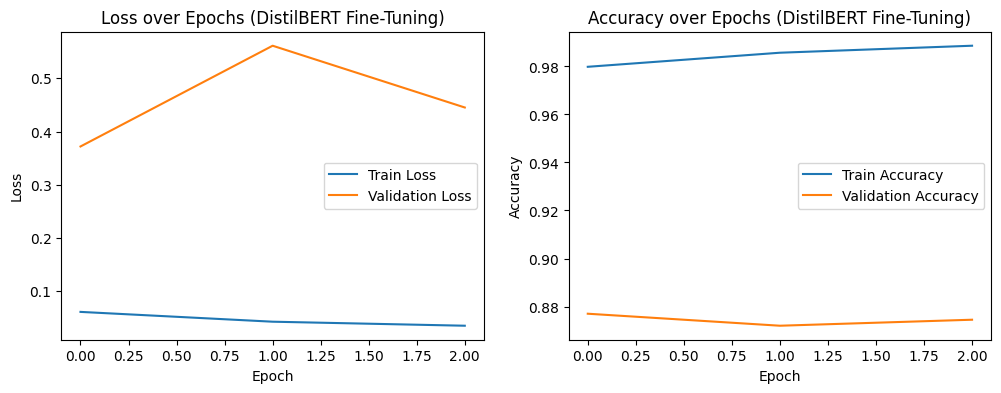

In [49]:
import matplotlib.pyplot as plt

# Loss curve

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Loss over Epochs (DistilBERT Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(valid_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Epochs (DistilBERT Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


# Confusion Matrix

/tmp/ipython-input-3808085645.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


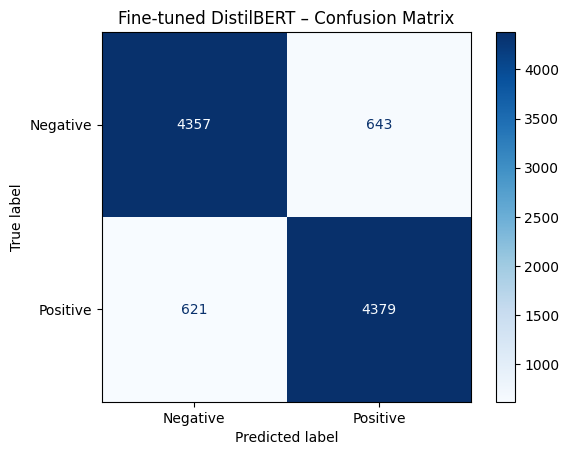

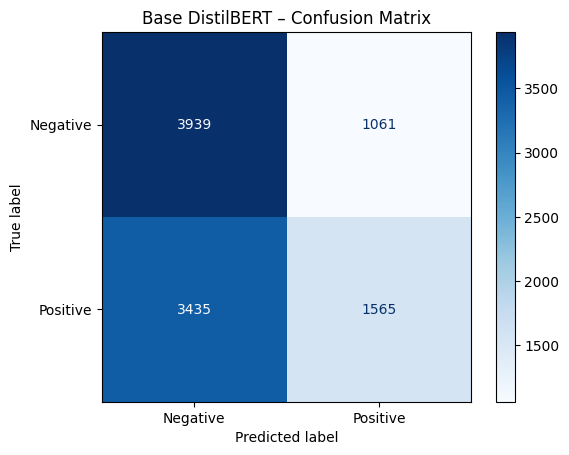

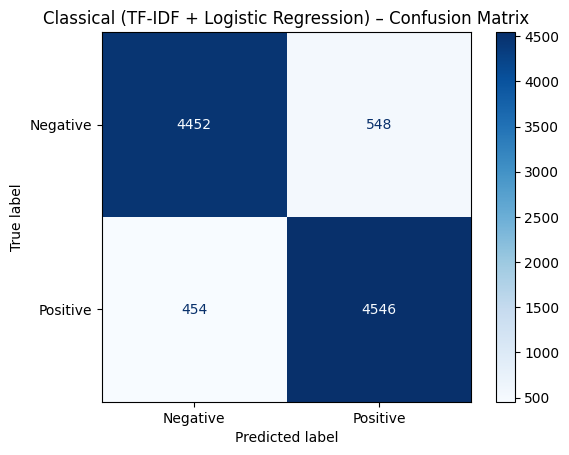

In [50]:
# Confusion Matrices for 3 Models

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Helper: extract label key ("label" or "labels")
def get_label_tensor(batch):
    if "label" in batch:
        return batch["label"]
    if "labels" in batch:
        return batch["labels"]
    raise KeyError("Batch does not contain label field.")

# Fine-tuned DistilBERT predictions
def get_preds_labels_distilbert(model_obj):
    model_obj.eval()
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = get_label_tensor(batch).to(device)

            outputs = model_obj(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            preds_all.extend(preds.cpu().numpy().tolist())
            labels_all.extend(labels.cpu().numpy().tolist())
    return np.array(preds_all), np.array(labels_all)

# Fine-tuned DistilBERT
ft_preds, ft_labels = get_preds_labels_distilbert(model)

# Base DistilBERT
base_preds, base_labels = get_preds_labels_distilbert(base_model)

# Classical TF-IDF model predictions
classical_preds = stat_model.predict(tfidf_vectorizer.transform(df_test["review"]))
classical_labels = df_test["label"].values

# Plot function
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative","Positive"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

# Plot all three
plot_confusion(ft_labels, ft_preds, "Fine-tuned DistilBERT – Confusion Matrix")
plot_confusion(base_labels, base_preds, "Base DistilBERT – Confusion Matrix")
plot_confusion(classical_labels, classical_preds, "Classical (TF-IDF + Logistic Regression) – Confusion Matrix")


# Precision, Accuracy and F1 score

In [51]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report
)

# Fine-tuned DistilBERT
ft_acc = accuracy_score(ft_labels, ft_preds)
ft_prec, ft_rec, ft_f1, _ = precision_recall_fscore_support(ft_labels, ft_preds, average='binary')

# Base DistilBERT
base_acc = accuracy_score(base_labels, base_preds)
base_prec, base_rec, base_f1, _ = precision_recall_fscore_support(base_labels, base_preds, average='binary')

# Classical Model
class_acc = accuracy_score(classical_labels, classical_preds)
class_prec, class_rec, class_f1, _ = precision_recall_fscore_support(classical_labels, classical_preds, average='binary')

# GPT-2 Zero-Shot (optional, slower)
# Run on a subset of test data (e.g., 300 samples) for speed
gpt_available = ("gpt_tok" in globals()) and ("gpt_model" in globals())

if gpt_available:
    sample_df = df_test.sample(300, random_state=42)
    gpt_preds = np.array([predict_gpt2(t) for t in sample_df["review"]])

    gpt_acc = accuracy_score(sample_df["label"], gpt_preds)
    gpt_prec, gpt_rec, gpt_f1, _ = precision_recall_fscore_support(sample_df["label"], gpt_preds, average='binary')
else:
    gpt_acc = gpt_prec = gpt_rec = gpt_f1 = None


print("=== Precision | Recall | F1 ===\n")

print(f"Classical TF-IDF Model: {class_prec:.4f} | {class_rec:.4f} | {class_f1:.4f}")
print(f"Base DistilBERT:       {base_prec:.4f} | {base_rec:.4f} | {base_f1:.4f}")
print(f"Fine-tuned DistilBERT: {ft_prec:.4f} | {ft_rec:.4f} | {ft_f1:.4f}")

if gpt_available:
    print(f"GPT-2 Zero-Shot:       {gpt_prec:.4f} | {gpt_rec:.4f} | {gpt_f1:.4f}")
else:
    print("GPT-2 not available — skipping.")


=== Precision | Recall | F1 ===

Classical TF-IDF Model: 0.8924 | 0.9092 | 0.9007
Base DistilBERT:       0.5960 | 0.3130 | 0.4104
Fine-tuned DistilBERT: 0.8720 | 0.8758 | 0.8739
GPT-2 Zero-Shot:       0.7321 | 0.8146 | 0.7712


# Performance Comparison

In [52]:
# Comparative Table (Accuracy, Precision, Recall, F1)

rows = []

rows.append({
    "Model": "Classical (TF-IDF + LR)",
    "Accuracy": class_acc,
    "Precision": class_prec,
    "Recall": class_rec,
    "F1-score": class_f1
})

rows.append({
    "Model": "Base DistilBERT",
    "Accuracy": base_acc,
    "Precision": base_prec,
    "Recall": base_rec,
    "F1-score": base_f1
})

rows.append({
    "Model": "Fine-tuned DistilBERT",
    "Accuracy": ft_acc,
    "Precision": ft_prec,
    "Recall": ft_rec,
    "F1-score": ft_f1
})

if gpt_available:
    rows.append({
        "Model": "GPT-2 Zero-Shot",
        "Accuracy": gpt_acc,
        "Precision": gpt_prec,
        "Recall": gpt_rec,
        "F1-score": gpt_f1
    })

performance_df = pd.DataFrame(rows)
performance_df


,Model,Accuracy,Precision,Recall,F1-score
0,Classical (TF-IDF + LR),0.899800,0.892422,0.90920,0.900733
1,Base DistilBERT,0.550400,0.595963,0.31300,0.410438
2,Fine-tuned DistilBERT,0.873600,0.871963,0.87580,0.873877
3,GPT-2 Zero-Shot,0.756667,0.732143,0.81457,0.771160


# Time Comparison

In [53]:
# STEP 6: Time Complexity Analysis (Inference)

import time

# measure inference time over 200 samples
sample_texts = df_test["review"].sample(200, random_state=42).tolist()

def time_inference(model_fn, texts, name):
    start = time.time()
    for t in texts:
        model_fn(t)
    end = time.time()
    avg_ms = ((end - start) / len(texts)) * 1000
    return avg_ms

# Timing functions for each model
time_classical = time_inference(predict_statistical, sample_texts, "Classical")
time_base_bert = time_inference(predict_base_distilbert, sample_texts, "Base BERT")
time_ft_bert = time_inference(predict_finetuned_distilbert, sample_texts, "Fine-tuned BERT")

if gpt_available:
    time_gpt = time_inference(predict_gpt2, sample_texts[:50], "GPT-2")  # small sample for speed
else:
    time_gpt = None

# Build Table
time_rows = [
    {"Model": "Classical TF-IDF Model", "Avg Inference (ms/sample)": time_classical},
    {"Model": "Base DistilBERT", "Avg Inference (ms/sample)": time_base_bert},
    {"Model": "Fine-tuned DistilBERT", "Avg Inference (ms/sample)": time_ft_bert},
]

if time_gpt is not None:
    time_rows.append({"Model": "GPT-2 Zero-Shot", "Avg Inference (ms/sample)": time_gpt})

time_df = pd.DataFrame(time_rows)
time_df


,Model,Avg Inference (ms/sample)
0,Classical TF-IDF Model,2.270093
1,Base DistilBERT,17.994519
2,Fine-tuned DistilBERT,15.889401
3,GPT-2 Zero-Shot,75.202498
